# Artificial Intelligence II (Deep Learning for Natural Language Processing)
# Homework 3

Name: Maria Miliou \
ID: 1115201300101 

## Import and install usefull packages

### Pandas, Numpy, Pytorch, sklearn, matplotlib

In [9]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import string
import random
import os

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.linalg.decomp import empty
from sklearn.metrics import f1_score, classification_report, recall_score,precision_score,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from torchtext import data
from nltk.lm import Vocabulary
from torchtext.vocab import build_vocab_from_iterator


In [10]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


### NLTK (Natural Language Toolkit)
To tokenize, lemmatize and remove stop words

In [11]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### GloVE 

In [13]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [14]:
#!ls -l
#!unzip glove*.zip

### Optuna

In [15]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading and Exploring Dataset


In [16]:
# Data file located at git
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading train set

In [17]:
train_df = pd.read_csv("/content/drive/MyDrive/imdb-reviews.csv", sep='\t')

print(train_df.describe())
train_df.head()

             rating
count  45008.000000
mean       5.481914
std        3.494293
min        1.000000
25%        2.000000
50%        7.000000
75%        9.000000
max       10.000000


,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


### Loading test set

In [18]:
test_df = pd.read_csv("/content/drive/MyDrive/imdb-reviews-test.csv", sep='\t') 

print(test_df.describe())
test_df.head()

            rating
count  5401.000000
mean      5.447695
std       3.495698
min       1.000000
25%       2.000000
50%       4.000000
75%       9.000000
max      10.000000


,review,rating
0,I saw this film at the 2002 Toronto Internatio...,9.0
1,The Stock Market Crash of 1929 and the Depress...,10.0
2,"Basically this is an overlong, unfunny, action...",1.0
3,And I am afraid that I cannot imagine why. It ...,1.0
4,Bubbling just beneath the surface of Showtime ...,4.0


### Find sentiment

In [19]:
#Train set
train_df['sentiment'] = train_df['rating'].apply(lambda x:0 if x<=4.0 else 1)
train_df.head()


,url,rating,review,sentiment
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,1


In [20]:
# Test set
if not(test_df.empty):
  test_df['sentiment'] = test_df['rating'].apply(lambda x:0 if x<=4.0 else 1)
  print(test_df.head())

                                              review  rating  sentiment
0  I saw this film at the 2002 Toronto Internatio...     9.0          1
1  The Stock Market Crash of 1929 and the Depress...    10.0          1
2  Basically this is an overlong, unfunny, action...     1.0          0
3  And I am afraid that I cannot imagine why. It ...     1.0          0
4  Bubbling just beneath the surface of Showtime ...     4.0          0


##Data Pre-processing


### Cleaning data from urls, email, digits and punctation and covert to lower case

In [21]:
def clean_data(df):
  df['review'] = df['review'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
  df['review'] = df['review'].replace(r'\S*@\S*\s?', '', regex=True)
  df['review'] = df['review'].str.replace('\d+', '', regex=True)
  df['review'] = df['review'].str.lower()
  df['review'] = df['review'].apply(lambda x:''.join([i for i in x  if i not in string.punctuation]))

clean_data(train_df)
if not(test_df.empty):
  clean_data(test_df)

train_df.head()


,url,rating,review,sentiment
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,i thought this was a quiet good movie it was f...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,wagon master is a very unique film amongst joh...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,this film has to be as near to perfect a film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,i gave this stars because it has a lot of int...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,this movie is really genuine and random its re...,1


In [22]:
test_df.head()

,review,rating,sentiment
0,i saw this film at the toronto international ...,9.0,1
1,the stock market crash of and the depression ...,10.0,1
2,basically this is an overlong unfunny actionco...,1.0,0
3,and i am afraid that i cannot imagine why it r...,1.0,0
4,bubbling just beneath the surface of showtime ...,4.0,0


### Tokenization, lemmatization and remove stopwords

In [23]:
# Define stop words
def stopwrds():
  mywords=frozenset(['not', 'no', 'didnt','cannot', 'couldnt', 'never'])
  stopw = ENGLISH_STOP_WORDS.union(['br'])
  stopw = stopw.difference(mywords)
  return list(stopw)

In [24]:
def process_data(data):
  tokenizer = RegexpTokenizer(r'\w+')
  wnl = WordNetLemmatizer()

  # Tokenize
  print("\nTokenization")
  reviews=[]
  for i in range(len(data)):
    reviews.append(tokenizer.tokenize(data.iloc[i]))
    
  # Removing stop words
  print("Removing stop words")
  reviews_stop=[]
  for i in range(len(reviews)):
    reviews_stop.append([word for word in reviews[i] if not word in stopwrds()])

  # Lemmatize
  print("Lemmatizing")
  reviews=[]
  for i in range(len(reviews_stop)):
    reviews.append([wnl.lemmatize(x) for x in reviews_stop[i]])
  return reviews

### GloVe

Transform GLOVe embeddings to Word2Vec format

In [25]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = '/content/drive/MyDrive/glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

Create a map with words as keys and vectors as values 


In [26]:
with open(w2v_output_file, 'r', encoding='UTF-8') as f:
  words = set()
  word_to_vec_map = {}
  for line in f:
    w_line = line.split()
    curr_word = w_line[0]
    word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float32)

### Split data to validation and train sets

In [27]:
X_train, X_val, y_train, y_val = train_test_split(train_df['review'], train_df['sentiment'], test_size=0.2)


### Perform cleaning and create word vectors

In [28]:
X_train=process_data(X_train)


Tokenization
Removing stop words
Lemmatizing


In [29]:
X_val=process_data(X_val)



Tokenization
Removing stop words
Lemmatizing


In [30]:
X_test=process_data(test_df['review'])


Tokenization
Removing stop words
Lemmatizing


Find the vocabulary of train data and create a embedding matrix where row i corresponds to embedding of word i in vocabulary

In [31]:
vocab=build_vocab_from_iterator(X_train,  specials=["<unk>"], max_tokens=5000)

In [32]:
words_index=vocab.get_stoi()
words_index

{'rave': 4999,
 'psychology': 4998,
 'predict': 4997,
 'millionaire': 4991,
 'marvel': 4990,
 'manbr': 4989,
 'located': 4988,
 'dive': 4979,
 'critique': 4975,
 'atrocity': 4971,
 'akshay': 4968,
 'surround': 4964,
 'steady': 4962,
 'specially': 4961,
 'fascination': 4950,
 'demonic': 4947,
 'boxer': 4944,
 'top': 4938,
 'token': 4937,
 'shoddy': 4935,
 'olivier': 4928,
 'nightclub': 4927,
 'misguided': 4926,
 'ma': 4925,
 'jealousy': 4922,
 'ignorance': 4921,
 'damon': 4915,
 'corporation': 4913,
 'carell': 4910,
 'attorney': 4909,
 'willie': 4908,
 'wholly': 4906,
 'ash': 4970,
 'studying': 4905,
 'rolebr': 4959,
 'scorsese': 4904,
 'mechanical': 4900,
 'transformed': 4966,
 'lush': 4899,
 'iv': 4894,
 'hilarity': 4891,
 'heartfelt': 4890,
 'firmly': 4889,
 'fanatic': 4888,
 'erika': 4887,
 'darn': 4883,
 'crawl': 4882,
 'camcorder': 4878,
 'article': 4875,
 'andre': 4873,
 'spectacle': 4866,
 'russo': 4863,
 'raising': 4859,
 'possession': 4858,
 'marked': 4856,
 'grainy': 4853,
 '

Create embedding matrix 

In [33]:
vocab_len = len(words_index)
embed_vector_len = word_to_vec_map['hello'].shape[0]
emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

Embeding matrix to torch

In [34]:
pretrained = torch.from_numpy(emb_matrix)

Replace tokens with correspoding index in vocabulary and perform padding to each review

In [35]:
#List of list different sizes -> (N reviews, ΜΑΧ_LEN)
def index_padd(token_data, words_index, MAX_LEN):

  # Tokens-> Vocabulary indices MAX_LEN
  reviews=np.zeros((len(token_data), MAX_LEN))
  for i in range(len(token_data)):
    indices=[]
    length=len(token_data[i])
    for word in token_data[i]:
      if word not in words_index.keys():
        indices.append(0)
      else: 
        indices.append(words_index[word])
    # Padding 
    if length<=MAX_LEN:
      reviews[i, :length] = indices
    else:
      reviews[i, :] = indices[:MAX_LEN]
  return reviews

In [36]:
x_train = index_padd(X_train, words_index, 100)
x_val = index_padd(X_val, words_index, 100)
x_test = index_padd(X_test, words_index, 100)

### Convert to tensor

In [37]:
#x = torch.tensor(np.asarray(X_train), dtype=torch.float32)
# Train
X = torch.from_numpy(x_train)
y = torch.tensor(y_train.to_numpy())

print(f"X train shape: {X.shape}")
print(f"y train shape: {y.shape}")

# Validation
#x_test = torch.tensor(np.asarray(X_val), dtype=torch.float)
Xval = torch.from_numpy(x_val)
yval = torch.tensor(y_val.to_numpy())#y_val.to_numpy().reshape(y_val.shape[0], 1), dtype=torch.float32

print(f"X val shape: {Xval.shape}")
print(f"y val shape: {yval.shape}")

# Test
Xtest = torch.from_numpy(x_test)
ytest = torch.tensor(test_df['sentiment'].to_numpy())

print(f"X test shape: {Xtest.shape}")
print(f"y test shape: {ytest.shape}")


X train shape: torch.Size([36006, 100])
y train shape: torch.Size([36006])
X val shape: torch.Size([9002, 100])
y val shape: torch.Size([9002])
X test shape: torch.Size([5401, 100])
y test shape: torch.Size([5401])


### Dataloaders

In [38]:
#Initialize dataloaders

train_dataset = torch.utils.data.TensorDataset(X, y)
val_dataset = torch.utils.data.TensorDataset(Xval, yval)
test_dataset = torch.utils.data.TensorDataset(Xtest, ytest)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=512)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

## Training, evaluation and testing

### Define training and evaluation procedure

In [39]:
def train(model, dataloader, val_dataloader, lr, epochs, clip):
  # Loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_metrics=[[],[],[],[]]   # Loss, f1, precision, recall 
  valid_metrics=[[],[],[],[]]

  for epoch in range(epochs):
    
    # TRAIN
    model.train()
    loss_sum=0 ; f1=0; pr=0; rc=0
    for batch , y in dataloader:
      # Predict
      y_pred = model(batch.long().to(device))

      # Calculate loss and metrics
      loss = loss_function(y_pred, y.to(device))

      loss_sum +=loss.item()
      _, y_pred = torch.max(y_pred, 1)
      f1 += f1_score(y.cpu(), y_pred.cpu(), average='weighted')
      pr += precision_score(y.cpu(), y_pred.cpu(), average='weighted')
      rc += recall_score(y.cpu(), y_pred.cpu(), average='weighted')

      # Clip params
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    # Mean loss and metrics of this epoch
    train_metrics[0].append(loss_sum/len(dataloader))
    train_metrics[1].append(f1/len(dataloader))
    train_metrics[2].append(pr/len(dataloader))
    train_metrics[3].append(rc/len(dataloader))

    # EVALUATE
    with torch.no_grad():
      model.eval()
      loss_sum=0 ; f1=0; pr=0; rc=0
      for batch, y in val_dataloader:
        # Predict
        y_pred = model(batch.long().to(device))

        # Calculate loss and metrics
        loss = loss_function(y_pred, y.to(device))

        loss_sum +=loss.item()
        _, y_pred = torch.max(y_pred, 1)
        f1 += f1_score(y.cpu(), y_pred.cpu(), average='weighted')
        pr += precision_score(y.cpu(), y_pred.cpu(), average='weighted')
        rc += recall_score(y.cpu(), y_pred.cpu(), average='weighted')

    # Mean loss and metrics of this epoch
    valid_metrics[0].append(loss_sum/len(val_dataloader))
    valid_metrics[1].append(f1/len(val_dataloader))
    valid_metrics[2].append(pr/len(val_dataloader))
    valid_metrics[3].append(rc/len(val_dataloader))

    print(f"Epoch {epoch} TRAIN Loss: {train_metrics[0][-1]} F1-score: {train_metrics[1][-1]} Precision: {train_metrics[2][-1]} Recall: {train_metrics[3][-1]}")
    print(f"\tTEST Loss: {valid_metrics[0][-1]} F1-score: {valid_metrics[1][-1]} Precision: {valid_metrics[2][-1]} Recall: {valid_metrics[3][-1]}")

  return train_metrics, valid_metrics
  

### Define testing procedure

In [40]:
def test(model, test_dataloader):
   with torch.no_grad():
      model.eval()
      loss_sum=0 ; f1=0; pr=0; rc=0
      for batch, y in test_dataloader:
        # Predict
        y_pred = model(batch.long().to(device))

        _, y_pred = torch.max(y_pred, 1)
        f1 += f1_score(y.cpu(), y_pred.cpu(), average='weighted')
        pr += precision_score(y.cpu(), y_pred.cpu(), average='weighted')
        rc += recall_score(y.cpu(), y_pred.cpu(), average='weighted')
    
      print("F1 score: ", f1/len(test_dataloader))
      print("precision score: ", pr/len(test_dataloader))
      print("recall score: ", rc/len(test_dataloader))

      #disp = ConfusionMatrixDisplay(confusion_matrix(ytest, y_pred), display_labels=['negative', 'positive'])
      #disp.plot()
      #plt.show()
      

### Define functions for plotting

In [41]:
def plot_metric(metric, figure, list_x, valid_metric, train_metric):
  plt.subplot(1, 4, figure)
  plt.plot(list_x, valid_metric, label = "Validation")
  plt.plot(list_x, train_metric, label = "Training")
  plt.legend()
  plt.ylabel(metric)
  plt.xlabel("epochs")

def plot_metrics(epochs, valid_metric, train_metric):
  plt.figure(figsize=(20, 5))

  list_x = [x for x in range(epochs)] 

  plot_metric("Loss", 1, list_x, valid_metric[0], train_metric[0])
  plot_metric("F1-score", 2, list_x, valid_metric[1], train_metric[1])
  plot_metric("Precision", 3, list_x, valid_metric[2], train_metric[2])
  plot_metric("Recall", 4, list_x, valid_metric[3], train_metric[3])

def plot_roc(model, train_dataloader, val_dataloader):

  with torch.no_grad():
    model.eval()

    # Train set
    fpr1=0
    tpr1=0
    for batch, y in train_dataloader:
      # Predict
      y_pred = model(batch.long().to(device))

      _, y_pred = torch.max(y_pred, 1)
          
      fpr, tpr, _ = roc_curve(y.cpu(), y_pred.cpu())
      fpr1 += fpr
      tpr1 += tpr

    roc_auc1 = auc(fpr1/len(train_dataloader), tpr1/len(train_dataloader))

    # Validation set
    fpr2=0
    tpr2=0
    for batch, y in val_dataloader:
      # Predict
      y_pred = model(batch.long().to(device))

      _, y_pred = torch.max(y_pred, 1)
          
      fpr, tpr, _ = roc_curve(y.cpu(), y_pred.cpu())
      fpr2 += fpr
      tpr2 += tpr

    roc_auc2 = auc(fpr2/len(val_dataloader), tpr2/len(val_dataloader))
  
    plt.figure()
    plt.plot(fpr1/len(train_dataloader),tpr1/len(train_dataloader), label="Train (AUC = {0:0.4f})".format(roc_auc1))
    plt.plot(fpr2/len(val_dataloader),tpr2/len(val_dataloader), label="Validation (AUC = {0:0.4f})".format(roc_auc2))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


In [42]:
cell='LSTM'
eval('nn.'+ cell)

torch.nn.modules.rnn.LSTM

## Create various models and trying different parameters

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Class Model 

In [53]:
class MY_RNN(nn.Module):
  def __init__(self, cell, num_embed, embed, embed_size, hidden_size, num_layers, drop=0, skip=False):
    super(MY_RNN, self).__init__()

    self.layers = num_layers
    self.hidden = hidden_size
    self.skip = skip

    # Embedding layer with GloVe
    self.embedding = nn.Embedding(num_embed, embed_size, device=device)
    self.embedding.weight.data.copy_(embed)

    # No learning
    self.embedding.weight.requires_grad = False
    
    # RNNs
    self.rnns = []
    for i in range(self.layers):
      if i==0:
        self.rnns.append(eval('nn.'+ cell)(embed_size, hidden_size, batch_first=True, bidirectional=True, device=device))
      else:
        self.rnns.append(eval('nn.'+ cell)(hidden_size, hidden_size, batch_first=True, bidirectional=True, device=device))
    #self.rnn1 = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True, device=device)
    #self.rnn2 = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True, device=device)

    self.rnns = nn.ModuleList(self.rnns)

    # Dropout
    self.dropout = nn.Dropout(drop)

    # Initialize final output linear layer
    self.linear = nn.Linear(hidden_size * 2, 3, device=device)
 

  def forward(self, x):
    # For skip connections
    identity = x

    # Embedding layer
    x = self.embedding(x)
    # Dropout
    x = self.dropout(x)

    # Stacked RNNs
    x, _ = self.rnns[0](x)
    
    for i in range(1, self.layers):
      # RNN
      out, _ = self.rnns[i](x[:, :, :self.hidden])

      # Skip connections 
      if (self.skip):
        out += identity
        # Dropout
      out = self.dropout(out)

      # Make output of this layer input to next
      x=out

    # Keep only last 
    out = out[:, -1, :]
    
    # Last but not least ---> Linear layer
    return self.linear(out)

   

### Testing

In [54]:
saved_model = torch.load('/content/drive/MyDrive/best_model', map_location=device)

In [55]:
test(saved_model, test_dataloader)

F1 score:  0.8932063282819754
precision score:  0.8945711914002055
recall score:  0.8932656047800065


### Try different hyperparameters using optuna

In [56]:
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

  cell = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
  hidden_size =  trial.suggest_categorical('hidden_size', [128, 512])
  num_layers = trial.suggest_categorical('num_layers', [2, 4])
  
  net = MY_RNN(cell, len(vocab), pretrained, 300, hidden_size, num_layers, drop=0.25, skip=False)
  print(net)

  epochs = 3
  LR = 0.01
  optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters
  loss_function = nn.CrossEntropyLoss()
  clip=0.99

  print_every = 5
  for epoch in range(epochs):
    
    # TRAIN
    net.train()
    for step, (batch , y) in enumerate(train_dataloader):
      # Predict
      y_pred = net(batch.long().to(device))

      # Calculate loss and f1
      loss = loss_function(y_pred, y.to(device))
      
      # Clip params
      nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # evaluate every N batches
      if step % print_every == 0:

        # Do not calculate gradients
        with torch.no_grad():
          net.eval()
          loss_sum=0 ; f1_sum=0
          for batch, y in val_dataloader:
            # Predict
            y_pred = net(batch.long().to(device))

            # Calculate f1
            _, y_pred = torch.max(y_pred, 1)
            f1_sum += f1_score(y.cpu(), y_pred.cpu(), average='weighted')
          
          f1 = f1_sum/len(val_dataloader)
          print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| validation f1: %.2f' % f1)

        net.train()

  return f1

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-01-27 17:50:25,407] A new study created in memory with name: no-name-a341a047-3aa5-4137-a950-892b80fe3ebb


MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): LSTM(300, 128, batch_first=True, bidirectional=True)
    (1): LSTM(128, 128, batch_first=True, bidirectional=True)
    (2): LSTM(128, 128, batch_first=True, bidirectional=True)
    (3): LSTM(128, 128, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)
Epoch:  0 | train loss: 1.0770 | validation f1: 0.34
Epoch:  0 | train loss: 0.6926 | validation f1: 0.34
Epoch:  0 | train loss: 0.8071 | validation f1: 0.33
Epoch:  0 | train loss: 0.7788 | validation f1: 0.34
Epoch:  0 | train loss: 0.7435 | validation f1: 0.33
Epoch:  0 | train loss: 0.6959 | validation f1: 0.34
Epoch:  0 | train loss: 0.6981 | validation f1: 0.33
Epoch:  0 | train loss: 0.6976 | validation f1: 0.33
Epoch:  0 | train loss: 0.7053 | validation f1: 0.34
Epoch:  0 | train loss: 0.6936 | validation f1: 0.33
Epoch:  0 | train loss: 0.6910 | validation

[I 2023-01-27 17:52:05,360] Trial 0 finished with value: 0.34068131986154954 and parameters: {'cell_type': 'LSTM', 'hidden_size': 128, 'num_layers': 4}. Best is trial 0 with value: 0.34068131986154954.


Epoch:  2 | train loss: 0.6920 | validation f1: 0.34
MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): GRU(300, 512, batch_first=True, bidirectional=True)
    (1): GRU(512, 512, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)
Epoch:  0 | train loss: 1.0819 | validation f1: 0.42
Epoch:  0 | train loss: 1.5686 | validation f1: 0.48
Epoch:  0 | train loss: 1.0815 | validation f1: 0.48
Epoch:  0 | train loss: 0.7590 | validation f1: 0.50
Epoch:  0 | train loss: 0.7432 | validation f1: 0.45
Epoch:  0 | train loss: 0.7253 | validation f1: 0.40
Epoch:  0 | train loss: 0.7438 | validation f1: 0.52
Epoch:  0 | train loss: 0.7365 | validation f1: 0.45
Epoch:  0 | train loss: 0.7430 | validation f1: 0.53
Epoch:  0 | train loss: 0.6947 | validation f1: 0.40
Epoch:  0 | train loss: 0.7207 | validation f1: 0.36
Epoch:  0 | train loss: 0.7628 | validation f1: 0.54
Epoch:  0

[I 2023-01-27 17:56:50,273] Trial 1 finished with value: 0.6392519964036716 and parameters: {'cell_type': 'GRU', 'hidden_size': 512, 'num_layers': 2}. Best is trial 1 with value: 0.6392519964036716.


Epoch:  2 | train loss: 0.6451 | validation f1: 0.64
MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): GRU(300, 512, batch_first=True, bidirectional=True)
    (1): GRU(512, 512, batch_first=True, bidirectional=True)
    (2): GRU(512, 512, batch_first=True, bidirectional=True)
    (3): GRU(512, 512, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)
Epoch:  0 | train loss: 1.1113 | validation f1: 0.34
Epoch:  0 | train loss: 1.6543 | validation f1: 0.33
Epoch:  0 | train loss: 1.0294 | validation f1: 0.34
Epoch:  0 | train loss: 0.8380 | validation f1: 0.35
Epoch:  0 | train loss: 0.7979 | validation f1: 0.34
Epoch:  0 | train loss: 0.7329 | validation f1: 0.33
Epoch:  0 | train loss: 0.7216 | validation f1: 0.33
Epoch:  0 | train loss: 0.7309 | validation f1: 0.33
Epoch:  0 | train loss: 0.7429 | validation f1: 0.33
Epoch:  0 | train loss: 0.7048 | validation f1

[I 2023-01-27 18:06:52,722] Trial 2 finished with value: 0.5410734409243407 and parameters: {'cell_type': 'GRU', 'hidden_size': 512, 'num_layers': 4}. Best is trial 1 with value: 0.6392519964036716.


Epoch:  2 | train loss: 0.7004 | validation f1: 0.54
MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): LSTM(300, 128, batch_first=True, bidirectional=True)
    (1): LSTM(128, 128, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)
Epoch:  0 | train loss: 1.0702 | validation f1: 0.34
Epoch:  0 | train loss: 0.8223 | validation f1: 0.34
Epoch:  0 | train loss: 0.7680 | validation f1: 0.33
Epoch:  0 | train loss: 0.7017 | validation f1: 0.34
Epoch:  0 | train loss: 0.7017 | validation f1: 0.34
Epoch:  0 | train loss: 0.7064 | validation f1: 0.33
Epoch:  0 | train loss: 0.6953 | validation f1: 0.34
Epoch:  0 | train loss: 0.6977 | validation f1: 0.34
Epoch:  0 | train loss: 0.6984 | validation f1: 0.35
Epoch:  0 | train loss: 0.6880 | validation f1: 0.33
Epoch:  0 | train loss: 0.6936 | validation f1: 0.33
Epoch:  0 | train loss: 0.6972 | validation f1: 0.34
Epoch:  

[I 2023-01-27 18:07:51,474] Trial 3 finished with value: 0.8435671830513756 and parameters: {'cell_type': 'LSTM', 'hidden_size': 128, 'num_layers': 2}. Best is trial 3 with value: 0.8435671830513756.


Epoch:  2 | train loss: 0.3532 | validation f1: 0.84
MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): GRU(300, 512, batch_first=True, bidirectional=True)
    (1): GRU(512, 512, batch_first=True, bidirectional=True)
    (2): GRU(512, 512, batch_first=True, bidirectional=True)
    (3): GRU(512, 512, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)
Epoch:  0 | train loss: 1.0895 | validation f1: 0.34
Epoch:  0 | train loss: 1.0604 | validation f1: 0.33
Epoch:  0 | train loss: 1.5869 | validation f1: 0.36
Epoch:  0 | train loss: 0.9914 | validation f1: 0.38
Epoch:  0 | train loss: 0.8393 | validation f1: 0.33
Epoch:  0 | train loss: 0.7504 | validation f1: 0.38
Epoch:  0 | train loss: 0.7944 | validation f1: 0.41
Epoch:  0 | train loss: 1.3273 | validation f1: 0.34
Epoch:  0 | train loss: 0.7889 | validation f1: 0.38
Epoch:  0 | train loss: 0.7323 | validation f1

[I 2023-01-27 18:17:55,361] Trial 4 finished with value: 0.5728876087962618 and parameters: {'cell_type': 'GRU', 'hidden_size': 512, 'num_layers': 4}. Best is trial 3 with value: 0.8435671830513756.


Epoch:  2 | train loss: 0.6913 | validation f1: 0.57


### Learning curves for some models

Choosing some of the best models from optuna to check learning curves for overfitting/underfitting. Then trying tuning hyperparameters

####Model 1

In [62]:
model1 = MY_RNN('GRU', len(vocab), pretrained, 300, 128, 2, drop=0.25, skip=False)
model1

MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): GRU(300, 128, batch_first=True, bidirectional=True)
    (1): GRU(128, 128, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)

In [63]:
train_scores, validation_scores = train(model1, train_dataloader, val_dataloader, lr=0.001, epochs=9, clip=0.99)
 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0 TRAIN Loss: 0.7223313568343579 F1-score: 0.5085891370526888 Precision: 0.5432355274656908 Recall: 0.5276930786526387
	TEST Loss: 0.5877734985616472 F1-score: 0.7227881086950004 Precision: 0.7413395980444195 Recall: 0.7264802094985086
Epoch 1 TRAIN Loss: 0.4283397210315919 F1-score: 0.802947314758613 Precision: 0.8081901531850577 Recall: 0.8036918801968437
	TEST Loss: 0.3570771101448271 F1-score: 0.8370415187953475 Precision: 0.8373561358619832 Recall: 0.837060437639821
Epoch 2 TRAIN Loss: 0.36218314313552746 F1-score: 0.8388451711324619 Precision: 0.841375576237373 Recall: 0.8390774806974376
	TEST Loss: 0.3380444662438499 F1-score: 0.8462289417775011 Precision: 0.8464463385012733 Recall: 0.846239105611484
Epoch 3 TRAIN Loss: 0.3419799103703297 F1-score: 0.8480372492516272 Precision: 0.8501673994085804 Recall: 0.8482196833107076
	TEST Loss: 0.3293048358625836 F1-score: 0.8540157845556696 Precision: 0.8542785950213293 Recall: 0.854037769155481
Epoch 4 TRAIN Loss: 0.32804251682590

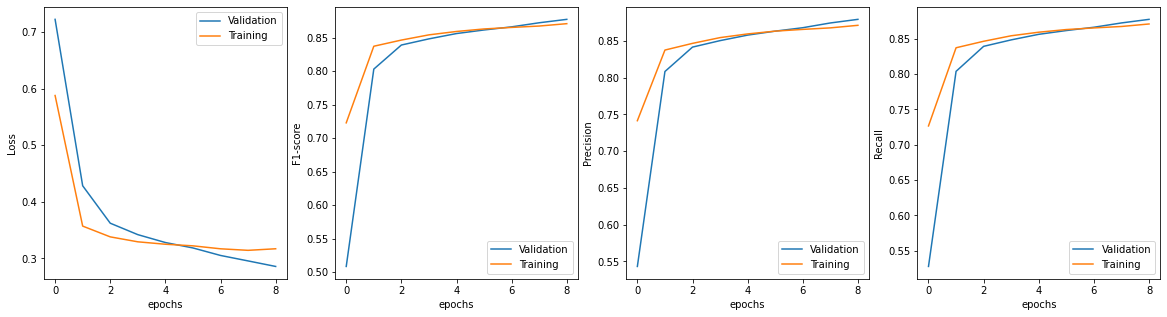

In [64]:
plot_metrics(9, train_scores, validation_scores)

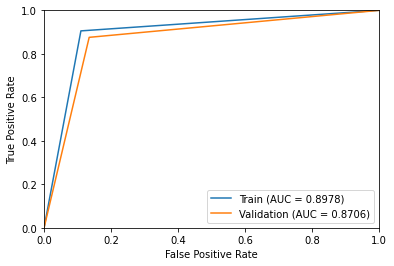

In [65]:
plot_roc(model1, train_dataloader, val_dataloader)


In [66]:
test(model1, test_dataloader)

F1 score:  0.8895339067236286
precision score:  0.8899849485794821
recall score:  0.8895369115981883


####Model 2

In [57]:
model2 = MY_RNN('LSTM', len(vocab), pretrained, 300, 128, 2, drop=0.25, skip=False)
model2

MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): LSTM(300, 128, batch_first=True, bidirectional=True)
    (1): LSTM(128, 128, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)

In [58]:
train_scores, validation_scores = train(model2, train_dataloader, val_dataloader, lr=0.001, epochs=9, clip=0.99)
 

Epoch 0 TRAIN Loss: 0.7371796696958407 F1-score: 0.4813455837019974 Precision: 0.5075215953730887 Recall: 0.5052979302774477
	TEST Loss: 0.6867512928114997 F1-score: 0.4889293924503121 Precision: 0.6287611495551046 Recall: 0.5612925871551081
Epoch 1 TRAIN Loss: 0.6796220289149755 F1-score: 0.5212083354576301 Precision: 0.5834829872670532 Recall: 0.5609489012387578
	TEST Loss: 0.6146512164009942 F1-score: 0.7062929143849213 Precision: 0.7278815829854145 Recall: 0.7121208811055183
Epoch 2 TRAIN Loss: 0.49681411620596766 F1-score: 0.7693691004333746 Precision: 0.7788880828942607 Recall: 0.7715248096258273
	TEST Loss: 0.4108133150471581 F1-score: 0.8225814745939672 Precision: 0.823011734283311 Recall: 0.8225678423284862
Epoch 3 TRAIN Loss: 0.4024348258972168 F1-score: 0.8192127765015547 Precision: 0.8234531611293752 Recall: 0.8197663011199728
	TEST Loss: 0.36774608658419716 F1-score: 0.8360502959301503 Precision: 0.836246656928882 Recall: 0.8360532892897091
Epoch 4 TRAIN Loss: 0.3769221767

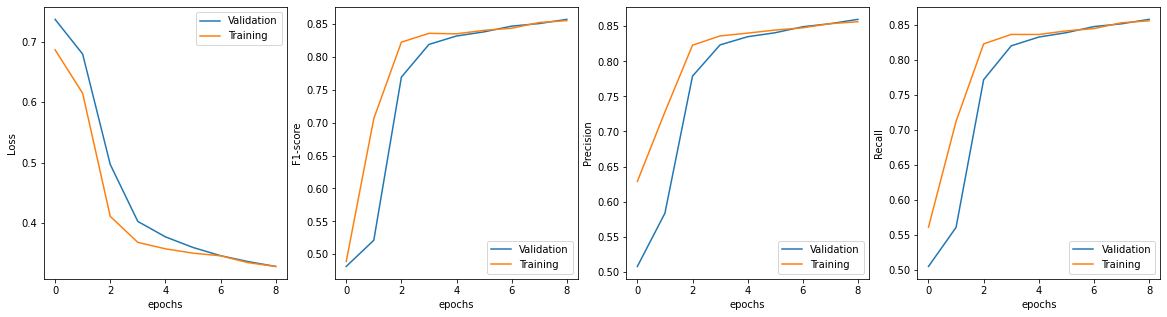

In [59]:
plot_metrics(9, train_scores, validation_scores)

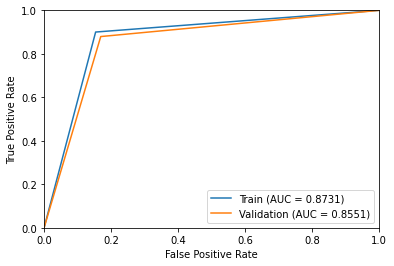

In [60]:
plot_roc(model2, train_dataloader, val_dataloader)


In [61]:
test(model2, test_dataloader)

F1 score:  0.8645721969445656
precision score:  0.8665298269781497
recall score:  0.8647029682950502


####Model 3

Try 80% clipping

In [67]:
model3 = MY_RNN('GRU', len(vocab), pretrained, 300, 128, 2, drop=0.25, skip=False)
model3

MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): GRU(300, 128, batch_first=True, bidirectional=True)
    (1): GRU(128, 128, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)

In [68]:
train_scores, validation_scores = train(model3, train_dataloader, val_dataloader, lr=0.001, epochs=9, clip=0.8)
 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0 TRAIN Loss: 0.7235841020731859 F1-score: 0.5068742816877853 Precision: 0.5354320775188093 Recall: 0.5271840000848464
	TEST Loss: 0.6082266933388181 F1-score: 0.7198682722757807 Precision: 0.728994670652385 Recall: 0.7216083205164057
Epoch 1 TRAIN Loss: 0.43309707876662135 F1-score: 0.7997756645319635 Precision: 0.8034033806773513 Recall: 0.8002831086670626
	TEST Loss: 0.3744354827536477 F1-score: 0.829062076596985 Precision: 0.8361207600173739 Recall: 0.8299907368568233
Epoch 2 TRAIN Loss: 0.36476720386827494 F1-score: 0.8361443028123067 Precision: 0.8393459368098739 Recall: 0.8364435956855591
	TEST Loss: 0.34139228363831836 F1-score: 0.8477118613407943 Precision: 0.8485122499998252 Recall: 0.8477276169835943
Epoch 3 TRAIN Loss: 0.3443720454061535 F1-score: 0.8487177754690892 Precision: 0.8503071263253206 Recall: 0.8488500657559817
	TEST Loss: 0.3290803035100301 F1-score: 0.8530372152717067 Precision: 0.8532480612608742 Recall: 0.853044457261372
Epoch 4 TRAIN Loss: 0.3301841213

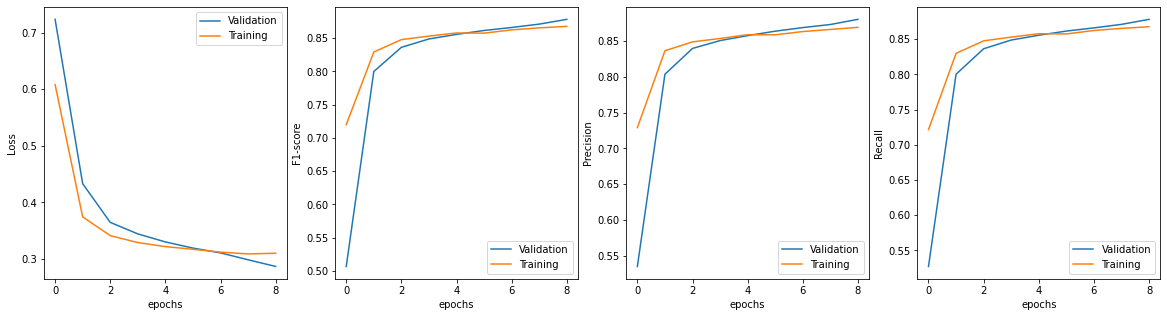

In [69]:
plot_metrics(9, train_scores, validation_scores)

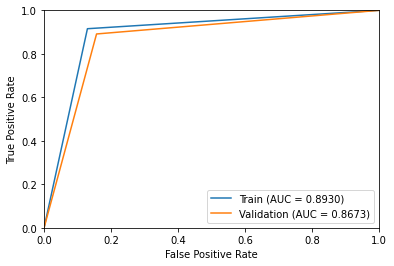

In [70]:
plot_roc(model3, train_dataloader, val_dataloader)


In [71]:
test(model3, test_dataloader)

F1 score:  0.8852648847924925
precision score:  0.8864991964422365
recall score:  0.8853191473228729


####Model 4

Try lr=0.01

In [72]:
model4 = MY_RNN('GRU', len(vocab), pretrained, 300, 128, 2, drop=0.25, skip=False)
model4

MY_RNN(
  (embedding): Embedding(5000, 300)
  (rnns): ModuleList(
    (0): GRU(300, 128, batch_first=True, bidirectional=True)
    (1): GRU(128, 128, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)

In [73]:
train_scores, validation_scores = train(model4, train_dataloader, val_dataloader, lr=0.01, epochs=9, clip=0.99)
 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

Epoch 0 TRAIN Loss: 0.5554051067627651 F1-score: 0.6696985984244612 Precision: 0.6884694003539216 Recall: 0.6931363216952316
	TEST Loss: 0.3756885793473985 F1-score: 0.8278693866512351 Precision: 0.8398700438235649 Recall: 0.8293870304343773
Epoch 1 TRAIN Loss: 0.3465460643801891 F1-score: 0.8463754299321831 Precision: 0.8509682023929049 Recall: 0.8467915455837435
	TEST Loss: 0.31835989157358807 F1-score: 0.8605987808525026 Precision: 0.8608847976853529 Recall: 0.8606290198545862
Epoch 2 TRAIN Loss: 0.2947837168901739 F1-score: 0.8740078671769683 Precision: 0.8756445457376367 Recall: 0.8741077867809266
	TEST Loss: 0.31577302515506744 F1-score: 0.8667550343214548 Precision: 0.8675069114202337 Recall: 0.8667833298378076
Epoch 3 TRAIN Loss: 0.26743617213108173 F1-score: 0.887212283731577 Precision: 0.8892468541602122 Recall: 0.8873580810919734
	TEST Loss: 0.3557456301318275 F1-score: 0.8531136929422738 Precision: 0.8614076428877091 Recall: 0.8539904339112603
Epoch 4 TRAIN Loss: 0.24707680

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7 TRAIN Loss: 0.2064237383679605 F1-score: 0.9147815354959078 Precision: 0.9175207559281563 Recall: 0.9148715239479043
	TEST Loss: 0.39441508717007107 F1-score: 0.8563101321810623 Precision: 0.8623680722638017 Recall: 0.856953620199478
Epoch 8 TRAIN Loss: 0.19708472259447607 F1-score: 0.9202311699494309 Precision: 0.922177618087592 Recall: 0.9202907581028338
	TEST Loss: 0.3614061839050717 F1-score: 0.8582371177956015 Precision: 0.8617860736250642 Recall: 0.8586088972781506


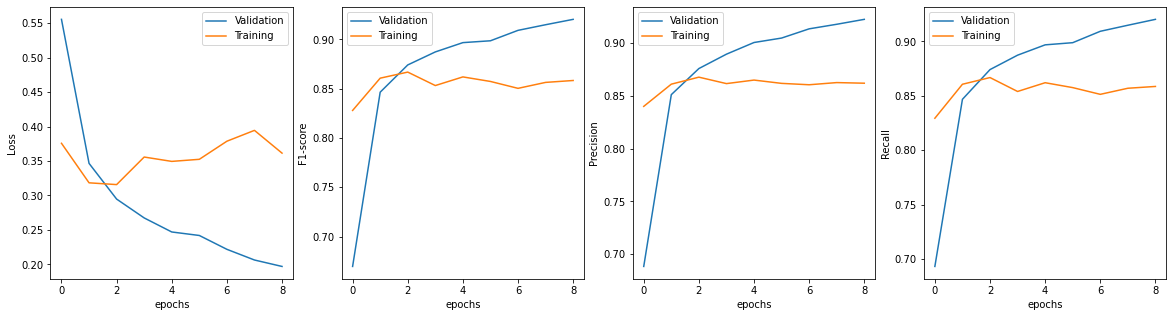

In [74]:
plot_metrics(9, train_scores, validation_scores)

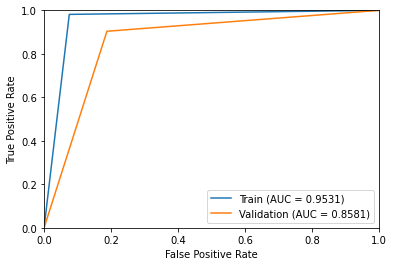

In [75]:
plot_roc(model4, train_dataloader, val_dataloader)


In [76]:
test(model4, test_dataloader)

F1 score:  0.9343049342646796
precision score:  0.9369009146588767
recall score:  0.9343835934972501


### My best model

In [ ]:
# Save best model
#torch.save(model1, '/content/drive/MyDrive/best_model')